In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from main import is_ai_related_article


import kagglehub
import os
import zipfile
import glob
import re

In [3]:
df = pd.read_csv("data/nyt-ai-sentiment.csv")
df


,pub_date,text,sentiment,sentiment_score
0,2000-02-03 05:00:00+00:00,"Hospitals nationwide, faced with growing conce...",neutral,0.677050
1,2000-06-18 05:00:00+00:00,Gerald Jonas reviews books Evolution's Darling...,neutral,0.637411
2,2000-07-25 05:00:00+00:00,Dr David B Fogel describes how computer progra...,neutral,0.595080
3,2000-07-29 05:00:00+00:00,Correction of July 17 article on Microsoft's p...,neutral,0.569639
4,2000-09-10 05:00:00+00:00,London Science Museum opens addition that expl...,neutral,0.819440
...,...,...,...,...
1006,2024-12-26 10:01:51+00:00,"As the technology is widely adopted, some once...",neutral,0.516346
1007,2024-12-28 12:00:03+00:00,The biggest thing holding America back from do...,negative,0.560552
1008,2024-12-29 08:00:41+00:00,"Frank Kendall, who grew up on an apple farm an...",neutral,0.649524
1009,2025-04-01 09:02:51+00:00,Advances in genetic testing and artificial int...,neutral,0.683855


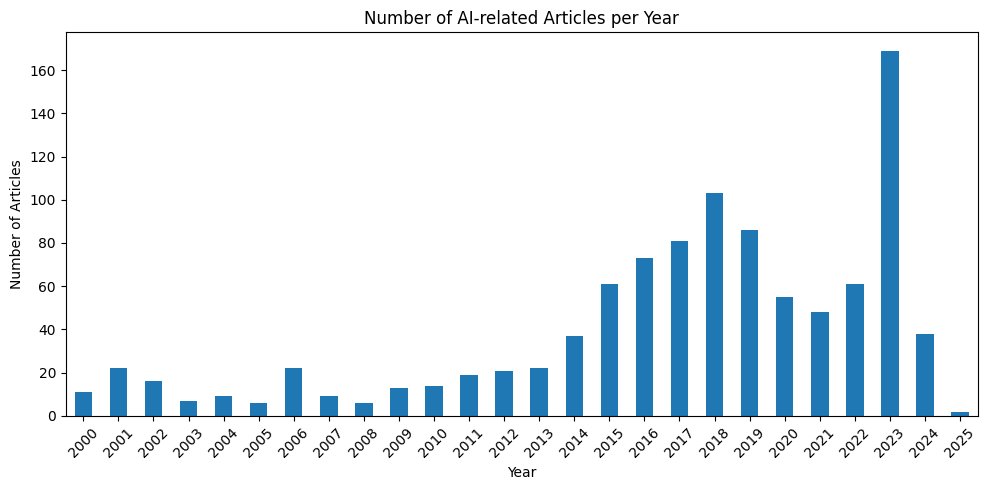

In [12]:
# plot the number of articles per year from 2000 to 2025
df['year'] = pd.to_datetime(df['pub_date']).dt.year
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Number of AI-related Articles per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('nyt_articles_per_year.png')
plt.show()

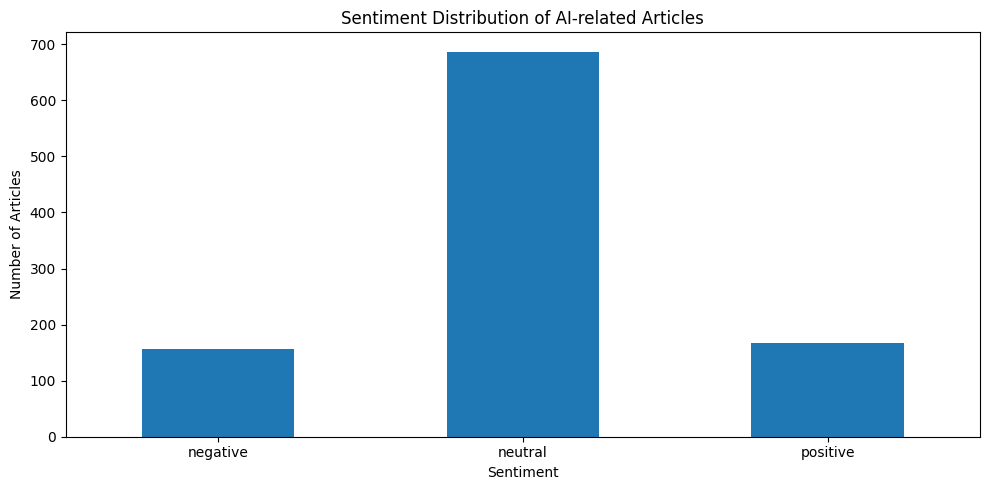

In [ ]:
df['sentiment'] = df['sentiment']
df['sentiment'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Sentiment Distribution of AI-related Articles')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('nyt_sentiment_distribution.png')
plt.show()

C:\Users\bogda\AppData\Local\Temp\ipykernel_11620\66069948.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1})


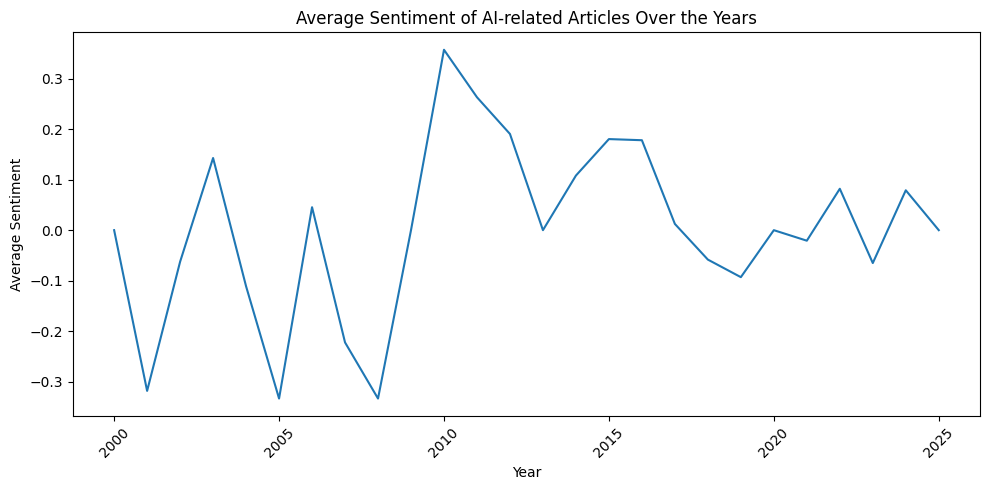

In [14]:
# plot how the sentiment changes over the years
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1})
df['sentiment'].groupby(df['year']).mean().plot(kind='line', figsize=(10, 5))
plt.title('Average Sentiment of AI-related Articles Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('nyt_sentiment_over_years.png')
plt.show()


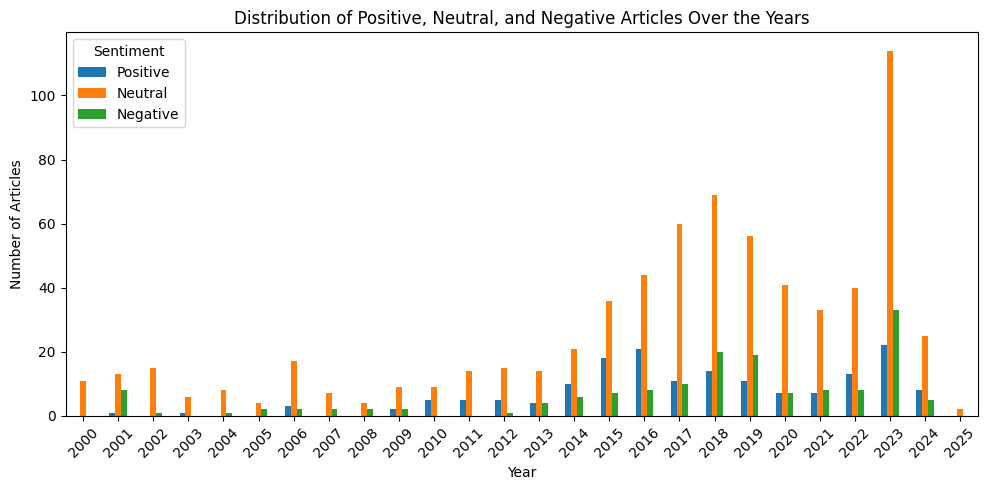

In [19]:
import matplotlib.pyplot as plt

# Replace sentiment values with numeric labels (if not already done)
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1})

# Group and unstack to prepare the data
sentiment_counts = df['sentiment'].groupby(df['year']).value_counts().unstack()

# Optional: Sort columns so the sentiment order is consistent
sentiment_counts = sentiment_counts[[1, 0, -1]]  # positive, neutral, negative

# Plot as grouped bars
sentiment_counts.plot(kind='bar', figsize=(10, 5))  # no stacked=True

# Customize plot
plt.title('Distribution of Positive, Neutral, and Negative Articles Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', labels=['Positive', 'Neutral', 'Negative'])
plt.tight_layout()
plt.savefig('nyt_sentiment_distribution_over_years.png')
plt.show()


C:\Users\sjouk\AppData\Local\Temp\ipykernel_13448\2730271109.py:24: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_full['pub_date'] = pd.to_datetime(df_full['pub_date'], errors='coerce', infer_datetime_format=True)


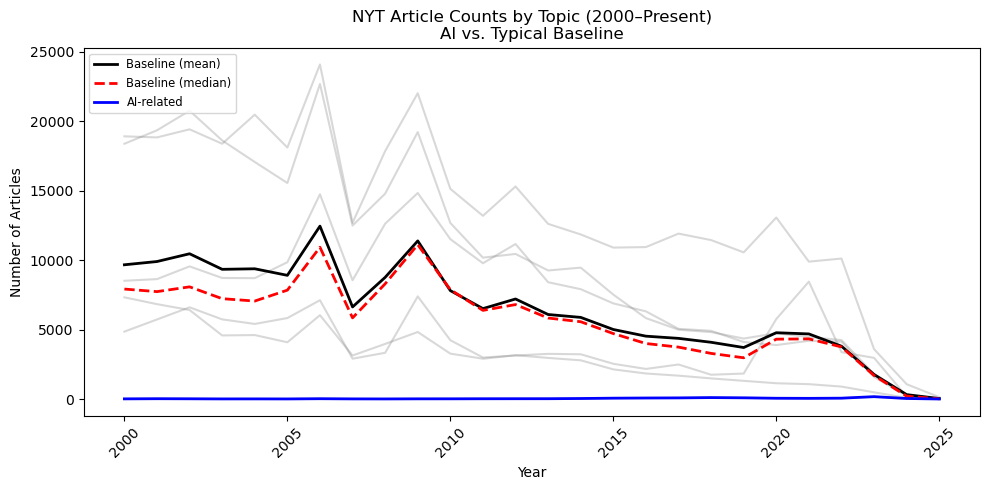

In [ ]:
extract_dir = kagglehub.dataset_download("aryansingh0909/nyt-articles-21m-2000-present")

csv = glob.glob(os.path.join(extract_dir, "**", "*.csv"), recursive=True)
for f in csv:
    if "metadata" in f.lower():
        metadata = f
        break

cols = ['pub_date','abstract','lead_paragraph','snippet','headline']
avail = pd.read_csv(metadata, nrows=0).columns.tolist()
use = []
for c in cols:
    if c in avail:
        use.append(c)
df_full = pd.read_csv(metadata, usecols=use, dtype=str)

texts = []
for col in ['abstract','lead_paragraph','snippet','headline']:
    if col in df_full.columns:
        texts.append(col)
df_full['text'] = df_full[texts].fillna('').agg(' '.join, axis=1).str.strip()

# put everything in UTC time
df_full['pub_date'] = pd.to_datetime(df_full['pub_date'], errors='coerce', infer_datetime_format=True)
df_full = df_full[df_full['pub_date'].notna()]

df_full['year'] = df_full['pub_date'].dt.year

df_full['pub_date'] = df_full['pub_date'].dt.tz_convert('UTC')
# df['pub_date'] = pd.to_datetime(df['pub_date'], utc=True, errors='coerce')
# merge with the sentiment data
# merged = df_full.merge(df[['pub_date','sentiment_score']], on='pub_date', how='left')
# merged['is_ai'] = merged['sentiment_score'].notna()
# df_full = merged

df_full['is_ai'] = df_full['text'].apply(is_ai_related_article)

TOPIC_CONFIG = {
    'Politics': {
        'keywords': ["election","government","senate","congress","policy","president","campaign"],
        'suffixes': ['election','campaign','policy','candidate','vote','government','legislation']
    },
    'Sports': {
        'keywords': ["game","team","player","season","soccer","football","world cup","olympics"],
        'suffixes': ['match','tournament','league','score','coach','player','team']
    },
    'Health': {
        'keywords': ["health","medicine","covid","vaccine","disease","hospital","mental health"],
        'suffixes': ['treatment','medicine','vaccine','hospital','doctor','disease','therapy']
    },
    'Business': {
        'keywords': ["stock","market","economy","business","finance","company"],
        'suffixes': ['insolvent','bubble','financing','investment','economy','company','trade']
    },
    'TechNoAI': {
        'keywords': ["technology","computer","software","internet","gadget","innovation","robotic"],
        'suffixes': ['software','hardware','gadget','device','circuit','network','application']
    }
}

def is_topic_related(text: str, keywords: list, suffixes: list, debug: bool=False) -> bool:
    if text is None or pd.isna(text) or not text.strip():
        return False
    txt = text.lower()
    primary = [kw for kw in keywords if ' ' in kw]
    single  = [kw for kw in keywords if ' ' not in kw]

    for term in primary:
        if term in txt:
            return True

    if single:
        pat = re.compile(r'\b(?:' + '|'.join(re.escape(k) for k in single) + r')\b')
        for m in pat.finditer(txt):
            kw = m.group(0)
            start = max(0, m.start() - 50)
            end   = min(len(txt), m.end() + 50)
            ctx = txt[start:end]

            for other in keywords:
                if other != kw and other in ctx:
                    return True

            suf_pattern = rf'{re.escape(kw)} (?:' + '|'.join(re.escape(s) for s in suffixes) + r')'
            if re.search(suf_pattern, ctx):
                return True

            use_pat = rf'(use of|using|powered by|based on|relies on|relied on) {re.escape(kw)}'
            if re.search(use_pat, ctx):
                return True

            return True
    return False
for name, cfg in TOPIC_CONFIG.items():
    df_full[f'is_{name}'] = df_full['text'].apply(
        lambda txt, kws=cfg['keywords'], sfx=cfg['suffixes']: is_topic_related(txt, kws, sfx)
    )

counts = (df_full.filter(regex=r'^is_').assign(year=df_full['year']).groupby('year').sum().rename(columns=lambda c: c.removeprefix('is_')).sort_index())

baseline_mean = counts.mean(axis=1)
baseline_med  = counts.median(axis=1)
ai_counts = df_full[df_full['is_ai']].groupby('year').size().reindex(counts.index, fill_value=0)

plt.figure(figsize=(10,5))
for c in counts.columns:
    plt.plot(counts.index, counts[c], alpha=0.3, color='gray')
plt.plot(baseline_mean.index, baseline_mean, color='black', lw=2, label='Baseline (mean)')
plt.plot(baseline_med.index, baseline_med, color='red', ls='--', lw=2, label='Baseline (median)')
plt.plot(ai_counts.index, ai_counts, color='blue', lw=2, label='AI-related')
plt.title("NYT Article Counts by Topic (2000–Present)\nAI vs. Typical Baseline")
plt.xlabel("Year"); plt.ylabel("Number of Articles")
plt.xticks(rotation=45); plt.legend(loc='upper left', fontsize='small')
plt.tight_layout(); plt.show()
